# Определение возраста покупателей

**Задание**

Построить модель для определения возраста человека по фотографии.

## Исследовательский анализ данных

In [1]:
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from PIL import Image

In [2]:
data = pd.read_csv('/datasets/faces/labels.csv')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [4]:
data.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [5]:
data['real_age'].describe()

count    7591.000000
mean       31.201159
std        17.145060
min         1.000000
25%        20.000000
50%        29.000000
75%        41.000000
max       100.000000
Name: real_age, dtype: float64

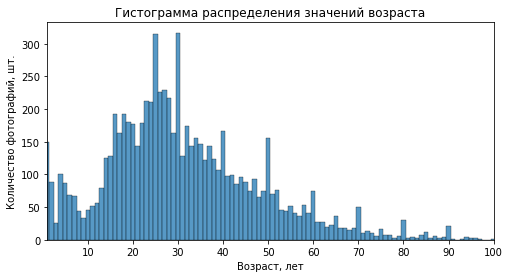

In [6]:
graph = sns.histplot(data=data, x='real_age', discrete=True)
graph.set(title='Гистограмма распределения значений возраста')
graph.set_xlabel('Возраст, лет')
graph.set_ylabel('Количество фотографий, шт.')
graph.set_xlim(data['real_age'].min(), data['real_age'].max())
graph.xaxis.set_major_locator(ticker.MultipleLocator(10))
graph.figure.set_figwidth(8)

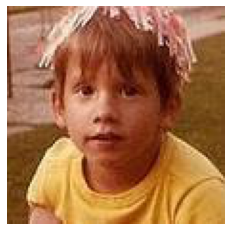

Age: 4 
Image size: (114, 114) 
FIlename: 000000.jpg 



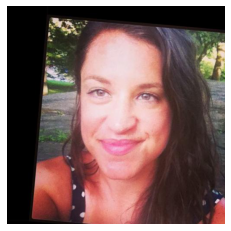

Age: 28 
Image size: (504, 504) 
FIlename: 000555.jpg 



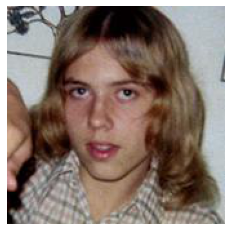

Age: 12 
Image size: (169, 169) 
FIlename: 001110.jpg 



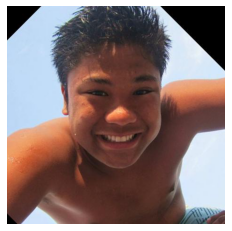

Age: 17 
Image size: (462, 461) 
FIlename: 001665.jpg 



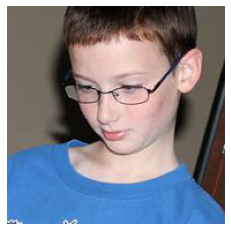

Age: 11 
Image size: (189, 189) 
FIlename: 002220.jpg 



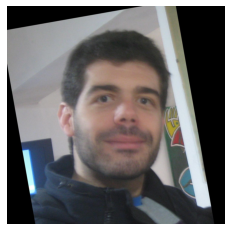

Age: 32 
Image size: (1436, 1436) 
FIlename: 002775.jpg 



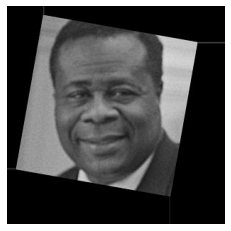

Age: 51 
Image size: (307, 307) 
FIlename: 003330.jpg 



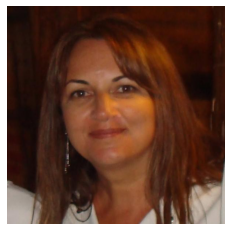

Age: 47 
Image size: (598, 598) 
FIlename: 003885.jpg 



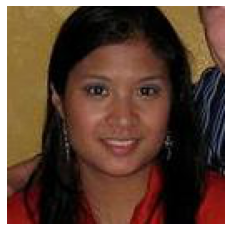

Age: 30 
Image size: (131, 131) 
FIlename: 004440.jpg 



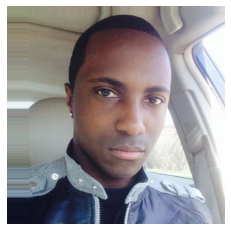

Age: 27 
Image size: (731, 732) 
FIlename: 004995.jpg 



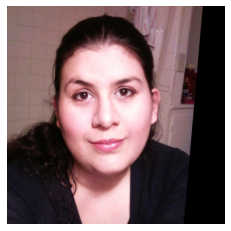

Age: 26 
Image size: (1146, 1146) 
FIlename: 005550.jpg 



In [7]:
for i in range(0,5555,555):
    image = Image.open('/datasets/faces/final_files/' + data.loc[i,'file_name'])
    plt.axis('off')
    plt.imshow(image)
    plt.show()
    print('Age:', data.loc[i,'real_age'],
          '\nImage size:', image.size,
          '\nFIlename:', data.loc[i,'file_name'],
          '\n=============================\n')

### Итог
* Количество фотографий в датасете: 7591. Предположительно, этого будет достаточно для решения задачи.
* На большинстве фотографий действительно представлены люди
* Большинство фотографий правильно повернуты и центрированы
* Фотографии имеют различный размер
* Возраст указан правдоподобно
    * Минимальный: 1
    * Максимальный: 100
    * Средний: 31
    * Медианный: 29
    * Имеются всплески количества фотографий в юбилейные годы, что может говорить о недостачно качественной разметке части данных (округлении)

## Обучение модели

### Код обучения модели

```python
import pandas as pd
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, AvgPool2D, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras.optimizers import Adam


def load_train(path):
    labels = pd.read_csv('/datasets/faces/labels.csv')

    datagen = ImageDataGenerator(validation_split=0.25,
                                 rescale=1./255
                                 #horizontal_flip=True,
                                 #vertical_flip=True,
                                 #rotation_range=90,
                                 #width_shift_range=0.2,
                                 #height_shift_range=0.2
                                )

    datagen_flow = datagen.flow_from_dataframe(
        labels,
        #directory=path,
        directory='/datasets/faces/final_files/',
        target_size=(224, 224),
        x_col='file_name',
        y_col='real_age',
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=12345)

    return datagen_flow


def load_test(path):
    labels = pd.read_csv('/datasets/faces/labels.csv')

    datagen = ImageDataGenerator(validation_split=0.25,
                                 rescale=1./255
                                )

    datagen_flow = datagen.flow_from_dataframe(
        labels,
        #directory=path,
        directory='/datasets/faces/final_files/',
        target_size=(224, 224),
        x_col='file_name',
        y_col='real_age',
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345)

    return datagen_flow


def create_model(input_shape):

    backbone = ResNet50(input_shape=input_shape,
                        weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
                        #weights='imagenet',
                        include_top=False) 

    #backbone.trainable = False

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu')) 

    optimizer=Adam(learning_rate=0.0001)

    model.compile(optimizer=optimizer, loss='mean_squared_error',
                  metrics=['mae'])
    return model

def train_model(model, train_datagen_flow, test_datagen_flow, batch_size=None,
                epochs=100,
                steps_per_epoch=None,
                validation_steps=None):

    model.fit(train_datagen_flow, 
              validation_data=test_datagen_flow,
              batch_size=batch_size, epochs=epochs,
              verbose=2, shuffle=True,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps) 

    return model



### Результат работы модели

Train for 178 steps, validate for 60 steps<br>
Epoch 1/100<br>
178/178 - 50s - loss: 224.0903 - mae: 10.7342 - val_loss: 766.4163 - val_mae: 22.7561<br>
Epoch 2/100<br>
178/178 - 42s - loss: 60.4777 - mae: 5.9332 - val_loss: 609.8122 - val_mae: 19.4989<br>
Epoch 3/100<br>
178/178 - 42s - loss: 30.2913 - mae: 4.2302 - val_loss: 214.9391 - val_mae: 10.9157<br>
Epoch 4/100<br>
178/178 - 41s - loss: 19.4203 - mae: 3.3749 - val_loss: 126.6822 - val_mae: 8.8096<br>
Epoch 5/100<br>
178/178 - 41s - loss: 14.3058 - mae: 2.9381 - val_loss: 82.6606 - val_mae: 6.8947<br>
Epoch 6/100<br>
178/178 - 42s - loss: 11.9661 - mae: 2.6406 - val_loss: 68.7463 - val_mae: 6.2701<br>
Epoch 7/100<br>
178/178 - 42s - loss: 9.7192 - mae: 2.3551 - val_loss: 70.4537 - val_mae: 6.4237<br>
Epoch 8/100<br>
178/178 - 42s - loss: 8.2404 - mae: 2.1783 - val_loss: 65.7718 - val_mae: 5.9836<br>
Epoch 9/100<br>
178/178 - 42s - loss: 7.6108 - mae: 2.0857 - val_loss: 71.7075 - val_mae: 6.4572<br>
Epoch 10/100<br>
178/178 - 42s - loss: 6.5397 - mae: 1.9480 - val_loss: 63.0592 - val_mae: 5.9321<br>
Epoch 11/100<br>
178/178 - 42s - loss: 5.7858 - mae: 1.8270 - val_loss: 68.6086 - val_mae: 6.1723<br>
Epoch 12/100<br>
178/178 - 41s - loss: 5.5909 - mae: 1.8030 - val_loss: 64.7279 - val_mae: 5.9622<br>
Epoch 13/100<br>
178/178 - 41s - loss: 5.9177 - mae: 1.8411 - val_loss: 64.4726 - val_mae: 5.9745<br>
Epoch 14/100<br>
178/178 - 41s - loss: 6.0658 - mae: 1.8401 - val_loss: 66.0028 - val_mae: 6.1213<br>
Epoch 15/100<br>
178/178 - 41s - loss: 5.7666 - mae: 1.8063 - val_loss: 63.7443 - val_mae: 6.0501<br>
Epoch 16/100<br>
178/178 - 41s - loss: 5.0565 - mae: 1.6890 - val_loss: 70.0626 - val_mae: 6.4993<br>
Epoch 17/100<br>
178/178 - 41s - loss: 4.9259 - mae: 1.6841 - val_loss: 65.1046 - val_mae: 6.1181<br>
Epoch 18/100<br>
178/178 - 41s - loss: 4.7867 - mae: 1.6605 - val_loss: 64.7524 - val_mae: 6.0557<br>
Epoch 19/100<br>
178/178 - 41s - loss: 5.1802 - mae: 1.7248 - val_loss: 67.6043 - val_mae: 6.2218<br>
Epoch 20/100<br>
178/178 - 41s - loss: 5.6717 - mae: 1.7812 - val_loss: 69.6239 - val_mae: 6.2241<br>
Epoch 21/100<br>
178/178 - 41s - loss: 5.4643 - mae: 1.7676 - val_loss: 68.1649 - val_mae: 6.3942<br>
Epoch 22/100<br>
178/178 - 42s - loss: 5.1467 - mae: 1.7174 - val_loss: 64.4756 - val_mae: 6.0298<br>
Epoch 23/100<br>
178/178 - 42s - loss: 4.8758 - mae: 1.6903 - val_loss: 63.9581 - val_mae: 5.9839<br>
Epoch 24/100<br>
178/178 - 41s - loss: 5.1148 - mae: 1.6911 - val_loss: 64.5337 - val_mae: 6.0417<br>
Epoch 25/100<br>
178/178 - 42s - loss: 5.0949 - mae: 1.6925 - val_loss: 64.0833 - val_mae: 5.9941<br>
Epoch 26/100<br>
178/178 - 41s - loss: 4.8173 - mae: 1.6484 - val_loss: 67.4862 - val_mae: 6.2597<br>
Epoch 27/100<br>
178/178 - 41s - loss: 4.6644 - mae: 1.6186 - val_loss: 66.7634 - val_mae: 6.2768<br>
Epoch 28/100<br>
178/178 - 42s - loss: 4.4606 - mae: 1.5826 - val_loss: 70.6103 - val_mae: 6.4335<br>
Epoch 29/100<br>
178/178 - 41s - loss: 4.2561 - mae: 1.5403 - val_loss: 60.5999 - val_mae: 5.7898<br>
Epoch 30/100<br>
178/178 - 42s - loss: 3.7661 - mae: 1.4386 - val_loss: 64.1589 - val_mae: 6.0046<br>
Epoch 31/100<br>
178/178 - 42s - loss: 3.8234 - mae: 1.4661 - val_loss: 62.0231 - val_mae: 5.9734<br>
Epoch 32/100<br>
178/178 - 42s - loss: 4.0442 - mae: 1.4932 - val_loss: 62.9615 - val_mae: 5.9936<br>
Epoch 33/100<br>
178/178 - 41s - loss: 4.1781 - mae: 1.5344 - val_loss: 60.5570 - val_mae: 5.7828<br>
Epoch 34/100<br>
178/178 - 42s - loss: 5.0727 - mae: 1.6822 - val_loss: 74.0204 - val_mae: 6.2808<br>
Epoch 35/100<br>
178/178 - 42s - loss: 13.4835 - mae: 2.7856 - val_loss: 70.0921 - val_mae: 6.2546<br>
Epoch 36/100<br>
178/178 - 41s - loss: 10.3644 - mae: 2.3900 - val_loss: 66.2150 - val_mae: 6.2672<br>
Epoch 37/100<br>
178/178 - 41s - loss: 5.2726 - mae: 1.6879 - val_loss: 62.6703 - val_mae: 5.8746<br>
Epoch 38/100<br>
178/178 - 41s - loss: 2.4311 - mae: 1.1661 - val_loss: 60.6155 - val_mae: 5.7699<br>
Epoch 39/100<br>
178/178 - 41s - loss: 1.3060 - mae: 0.8427 - val_loss: 62.4320 - val_mae: 5.8675<br>
Epoch 40/100<br>
178/178 - 42s - loss: 0.8265 - mae: 0.6716 - val_loss: 58.1947 - val_mae: 5.7167<br>
Epoch 41/100<br>
178/178 - 42s - loss: 0.5823 - mae: 0.5602 - val_loss: 59.2084 - val_mae: 5.7012<br>
Epoch 42/100<br>
178/178 - 41s - loss: 0.5379 - mae: 0.5337 - val_loss: 59.1617 - val_mae: 5.8099<br>
Epoch 43/100<br>
178/178 - 41s - loss: 0.6183 - mae: 0.5764 - val_loss: 58.8513 - val_mae: 5.7353<br>
Epoch 44/100<br>
178/178 - 42s - loss: 0.8693 - mae: 0.6865 - val_loss: 60.1641 - val_mae: 5.8518<br>
Epoch 45/100<br>
178/178 - 41s - loss: 1.4132 - mae: 0.8706 - val_loss: 62.7644 - val_mae: 5.9905<br>
Epoch 46/100<br>
178/178 - 42s - loss: 2.3047 - mae: 1.1203 - val_loss: 62.9064 - val_mae: 6.0412<br>
Epoch 47/100<br>
178/178 - 41s - loss: 3.3817 - mae: 1.3777 - val_loss: 60.4390 - val_mae: 5.7544<br>
Epoch 48/100<br>
178/178 - 41s - loss: 4.0994 - mae: 1.5171 - val_loss: 63.3149 - val_mae: 5.8350<br>
Epoch 49/100<br>
178/178 - 41s - loss: 4.2841 - mae: 1.5460 - val_loss: 73.7205 - val_mae: 6.2319<br>
Epoch 50/100<br>
178/178 - 42s - loss: 4.2423 - mae: 1.5471 - val_loss: 65.3892 - val_mae: 6.0431<br>
Epoch 51/100<br>
178/178 - 42s - loss: 3.8267 - mae: 1.4701 - val_loss: 64.1278 - val_mae: 6.1584<br>
Epoch 52/100<br>
178/178 - 41s - loss: 3.2665 - mae: 1.3543 - val_loss: 64.7098 - val_mae: 6.0110<br>
Epoch 53/100<br>
178/178 - 41s - loss: 2.6109 - mae: 1.2131 - val_loss: 66.8227 - val_mae: 6.3061<br>
Epoch 54/100<br>
178/178 - 41s - loss: 2.2149 - mae: 1.1111 - val_loss: 59.1723 - val_mae: 5.7157<br>
Epoch 55/100<br>
178/178 - 41s - loss: 2.0179 - mae: 1.0707 - val_loss: 60.1902 - val_mae: 5.7004<br>
Epoch 56/100<br>
178/178 - 41s - loss: 1.8050 - mae: 1.0101 - val_loss: 61.4506 - val_mae: 5.7183<br>
Epoch 57/100<br>
178/178 - 41s - loss: 1.6269 - mae: 0.9529 - val_loss: 59.6350 - val_mae: 5.7572<br>
Epoch 58/100<br>
178/178 - 42s - loss: 1.6498 - mae: 0.9531 - val_loss: 57.9741 - val_mae: 5.6277<br>
Epoch 59/100<br>
178/178 - 41s - loss: 1.7826 - mae: 0.9832 - val_loss: 60.1785 - val_mae: 5.7296<br>
Epoch 60/100<br>
178/178 - 42s - loss: 1.9102 - mae: 1.0273 - val_loss: 58.9970 - val_mae: 5.7262<br>
Epoch 61/100<br>
178/178 - 41s - loss: 2.1287 - mae: 1.0868 - val_loss: 60.9080 - val_mae: 5.8421<br>
Epoch 62/100<br>
178/178 - 41s - loss: 2.2094 - mae: 1.1165 - val_loss: 57.9766 - val_mae: 5.6386<br>
Epoch 63/100<br>
178/178 - 41s - loss: 2.2712 - mae: 1.1283 - val_loss: 64.7768 - val_mae: 5.9952<br>
Epoch 64/100<br>
178/178 - 40s - loss: 2.5153 - mae: 1.1839 - val_loss: 59.8581 - val_mae: 5.6878<br>
Epoch 65/100<br>
178/178 - 41s - loss: 2.5137 - mae: 1.1806 - val_loss: 63.4473 - val_mae: 5.9383<br>
Epoch 66/100<br>
178/178 - 42s - loss: 2.3006 - mae: 1.1203 - val_loss: 59.1931 - val_mae: 5.6305<br>
Epoch 67/100<br>
178/178 - 42s - loss: 2.1870 - mae: 1.0920 - val_loss: 67.2967 - val_mae: 5.9075<br>
Epoch 68/100<br>
178/178 - 41s - loss: 1.9580 - mae: 1.0490 - val_loss: 61.1309 - val_mae: 5.8606<br>
Epoch 69/100<br>
178/178 - 42s - loss: 1.8123 - mae: 1.0194 - val_loss: 64.0615 - val_mae: 5.9906<br>
Epoch 70/100<br>
178/178 - 42s - loss: 1.6899 - mae: 0.9831 - val_loss: 60.2080 - val_mae: 5.7456<br>
Epoch 71/100<br>
178/178 - 41s - loss: 1.5138 - mae: 0.9356 - val_loss: 60.0046 - val_mae: 5.7490<br>
Epoch 72/100<br>
178/178 - 41s - loss: 1.4059 - mae: 0.8895 - val_loss: 56.1982 - val_mae: 5.5599<br>
Epoch 73/100<br>
178/178 - 42s - loss: 1.3507 - mae: 0.8722 - val_loss: 60.2255 - val_mae: 5.7811<br>
Epoch 74/100<br>
178/178 - 41s - loss: 1.4685 - mae: 0.9038 - val_loss: 59.5088 - val_mae: 5.8057<br>
Epoch 75/100<br>
178/178 - 42s - loss: 1.6317 - mae: 0.9483 - val_loss: 64.2982 - val_mae: 5.8629<br>
Epoch 76/100<br>
178/178 - 42s - loss: 1.8711 - mae: 1.0136 - val_loss: 70.3353 - val_mae: 6.4676<br>
Epoch 77/100<br>
178/178 - 41s - loss: 1.8863 - mae: 1.0262 - val_loss: 60.5375 - val_mae: 5.7605<br>
Epoch 78/100<br>
178/178 - 41s - loss: 1.8200 - mae: 1.0201 - val_loss: 59.1854 - val_mae: 5.6370<br>
Epoch 79/100<br>
178/178 - 41s - loss: 1.6610 - mae: 0.9795 - val_loss: 61.1807 - val_mae: 5.8911<br>
Epoch 80/100<br>
178/178 - 42s - loss: 1.7065 - mae: 0.9800 - val_loss: 58.4059 - val_mae: 5.5380<br>
Epoch 81/100<br>
178/178 - 42s - loss: 1.5933 - mae: 0.9468 - val_loss: 59.1040 - val_mae: 5.7154<br>
Epoch 82/100<br>
178/178 - 41s - loss: 1.4015 - mae: 0.8817 - val_loss: 59.3439 - val_mae: 5.6569<br>
Epoch 83/100<br>
178/178 - 43s - loss: 1.2396 - mae: 0.8416 - val_loss: 60.2880 - val_mae: 5.6785<br>
Epoch 84/100<br>
178/178 - 42s - loss: 1.1381 - mae: 0.7979 - val_loss: 61.5562 - val_mae: 5.9084<br>
Epoch 85/100<br>
178/178 - 41s - loss: 1.0606 - mae: 0.7636 - val_loss: 61.2466 - val_mae: 5.6934<br>
Epoch 86/100<br>
178/178 - 41s - loss: 0.9889 - mae: 0.7471 - val_loss: 58.8892 - val_mae: 5.6581<br>
Epoch 87/100<br>
178/178 - 41s - loss: 1.0497 - mae: 0.7647 - val_loss: 60.2801 - val_mae: 5.7091<br>
Epoch 88/100<br>
178/178 - 42s - loss: 1.1364 - mae: 0.8095 - val_loss: 58.5232 - val_mae: 5.6483<br>
Epoch 89/100<br>
178/178 - 42s - loss: 1.3179 - mae: 0.8726 - val_loss: 63.6055 - val_mae: 5.8289<br>
Epoch 90/100<br>
178/178 - 42s - loss: 1.5505 - mae: 0.9278 - val_loss: 62.2488 - val_mae: 5.8326<br>
Epoch 91/100<br>
178/178 - 42s - loss: 11.5087 - mae: 2.0927 - val_loss: 316.7019 - val_mae: 13.7370<br>
Epoch 92/100<br>
178/178 - 42s - loss: 10.4608 - mae: 2.3508 - val_loss: 72.5442 - val_mae: 6.3604<br>
Epoch 93/100<br>
178/178 - 41s - loss: 3.2076 - mae: 1.3410 - val_loss: 60.7776 - val_mae: 5.7673<br>
Epoch 94/100<br>
178/178 - 41s - loss: 1.8893 - mae: 0.9550 - val_loss: 61.8512 - val_mae: 5.8025<br>
Epoch 95/100<br>
178/178 - 41s - loss: 0.5931 - mae: 0.5622 - val_loss: 60.4893 - val_mae: 5.7665<br>
Epoch 96/100<br>
178/178 - 42s - loss: 0.1918 - mae: 0.3269 - val_loss: 60.1770 - val_mae: 5.7641<br>
Epoch 97/100<br>
178/178 - 42s - loss: 0.0896 - mae: 0.2181 - val_loss: 60.0189 - val_mae: 5.7475<br>
Epoch 98/100<br>
178/178 - 42s - loss: 0.0451 - mae: 0.1543 - val_loss: 60.0628 - val_mae: 5.7509<br>
Epoch 99/100<br>
178/178 - 42s - loss: 0.0301 - mae: 0.1251 - val_loss: 59.8398 - val_mae: 5.7465<br>
Epoch 100/100<br>
178/178 - 42s - loss: 0.0286 - mae: 0.1178 - val_loss: 59.8877 - val_mae: 5.7526<br>
<br>
60/60 - 10s - loss: 59.8877 - mae: 5.7526<br>
<b>Test MAE: 5.7526</b>

## Анализ обученной модели

In [8]:
result = [22.7561, 19.4989, 10.9157, 8.8096, 6.8947, 6.2701, 6.4237, 5.9836, 6.4572, 5.9321, 6.1723, 5.9622, 5.9745,
          6.1213, 6.0501, 6.4993, 6.1181, 6.0557, 6.2218, 6.2241, 6.3942, 6.0298, 5.9839, 6.0417, 5.9941, 6.2597,
          6.2768, 6.4335, 5.7898, 6.0046, 5.9734, 5.9936, 5.7828, 6.2808, 6.2546, 6.2672, 5.8746, 5.7699, 5.8675,
          5.7167, 5.7012, 5.8099, 5.7353, 5.8518, 5.9905, 6.0412, 5.7544, 5.8350, 6.2319, 6.0431, 6.1584, 6.0110,
          6.3061, 5.7157, 5.7004, 5.7183, 5.7572, 5.6277, 5.7296, 5.7262, 5.8421, 5.6386, 5.9952, 5.6878, 5.9383,
          5.6305, 5.9075, 5.8606, 5.9906, 5.7456, 5.7490, 5.5599, 5.7811, 5.8057, 5.8629, 6.4676, 5.7605, 5.6370,
          5.8911, 5.5380, 5.7154, 5.6569, 5.6785, 5.9084, 5.6934, 5.6581, 5.7091, 5.6483, 5.8289, 5.8326, 13.7370,
          6.3604, 5.7673, 5.8025, 5.7665, 5.7641, 5.7475, 5.7509, 5.7465, 5.7526]

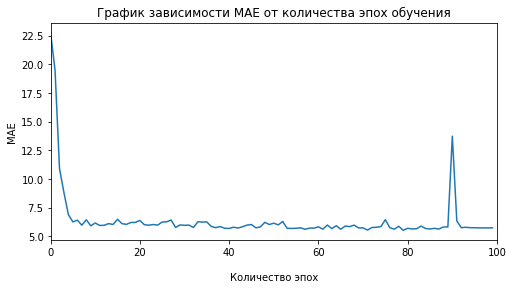

In [9]:
graph = sns.lineplot(data=result, legend=False)
graph.set(title='График зависимости MAE от количества эпох обучения')
graph.set_xlabel('\nКоличество эпох')
graph.set_ylabel('MAE')
graph.set_xlim(0,100)
graph.figure.set_figwidth(8)

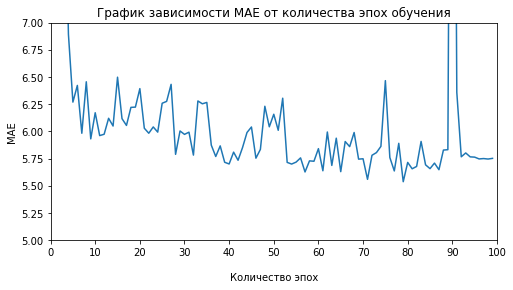

In [10]:
graph = sns.lineplot(data=result, legend=False)
graph.set(title='График зависимости MAE от количества эпох обучения')
graph.set_xlabel('\nКоличество эпох')
graph.set_ylabel('MAE')
graph.xaxis.set_major_locator(ticker.MultipleLocator(10))
graph.set_xlim(0,100)
graph.set_ylim(5,7)
graph.figure.set_figwidth(8)

### Итог

Судя по всему, количество эпох было выбрано слегка избыточно, что, однако, позволило более полно рассмотреть динамику MAE после прохождения оптимума.<br>
Оптимальным представляется число эпох, равное 80.

## Выводы

Для решения задачи определения возраста по фото была выбрана нейросетевая модель ResNet50 с алгоритмом обучения Adam (learning_rate=0.0001) и функцией потерь MSE.<br>
Количество эпох было выбрано равным 100, что оказалось избыточным. Оптимальное значение: 80.<br>
Результат: <b>MAE на тестовой выборке 5.7526</b>